In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
# df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
# df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [4]:
PROCESSED_TRAIN = '20190618_dist_bond_cos3j_train.csv'
MODEL = '20190621_champs_models_lgb.pickle'

In [5]:
df_train_dist = pd.read_csv(OUTPUT + PROCESSED_TRAIN)

In [6]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [7]:
mols = df_train_dist['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.8)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [8]:
bond_types = df_train_dist['type'].unique()

models = []
scores = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':0
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=20000,
            valid_sets=lgb_eval,
                    verbose_eval=100,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
    score = type_score(y_val, y_pred)
    scores = np.hstack([scores, score])
    models.append(gbm)

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's l2: 3.71517
[200]	valid_0's l2: 2.78673
[300]	valid_0's l2: 2.3894
[400]	valid_0's l2: 2.17447
[500]	valid_0's l2: 2.0214
[600]	valid_0's l2: 1.90554
[700]	valid_0's l2: 1.81097
[800]	valid_0's l2: 1.73718
[900]	valid_0's l2: 1.67932
[1000]	valid_0's l2: 1.63481
[1100]	valid_0's l2: 1.59567
[1200]	valid_0's l2: 1.56037
[1300]	valid_0's l2: 1.53128
[1400]	valid_0's l2: 1.50526
[1500]	valid_0's l2: 1.48302
[1600]	valid_0's l2: 1.46156
[1700]	valid_0's l2: 1.445
[1800]	valid_0's l2: 1.42914
[1900]	valid_0's l2: 1.41337
[2000]	valid_0's l2: 1.40107
[2100]	valid_0's l2: 1.38991
[2200]	valid_0's l2: 1.3788
[2300]	valid_0's l2: 1.36881
[2400]	valid_0's l2: 1.36053
[2500]	valid_0's l2: 1.35102
[2600]	valid_0's l2: 1.34335
[2700]	valid_0's l2: 1.33668
Early stopping, best iteration is:
[2743]	valid_0's l2: 1.3339
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's l2: 0.368055
[200]	valid_0's

LightGBMError: Check failed: num_data > 0 at D:\a\1\s\python-package\compile\src\io\dataset.cpp, line 27 .


In [9]:
print('type score:', scores)
print('total score:', scores.mean())

# type score: [-0.4735228  -1.70507637 -1.02514106 -1.60275171 -1.13635603 -0.37426881
#  -0.40711649 -1.69301447]
# total score: -1.0521559664830797


type score: [-0.28740103 -1.47937001 -0.61124842 -1.20159237 -1.01912723 -1.47099784
 -0.48181884 -1.44911017]
total score: -1.000083239352652


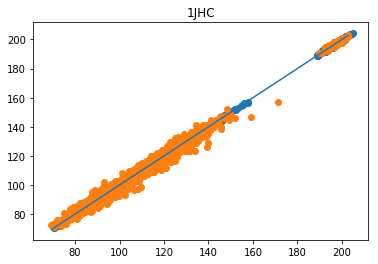

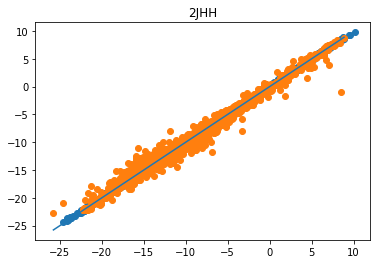

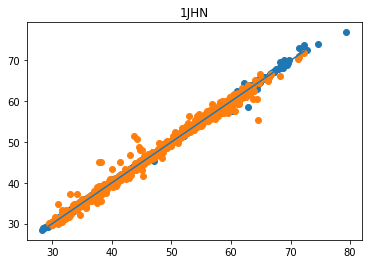

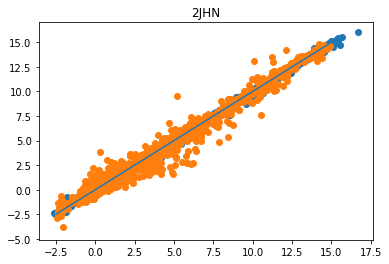

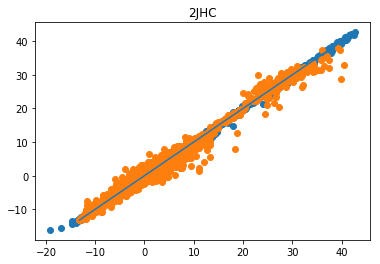

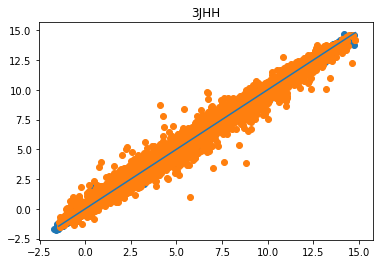

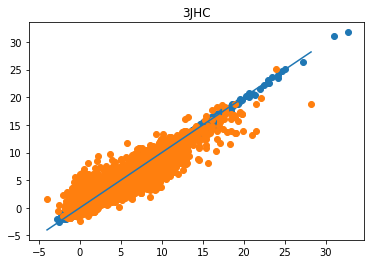

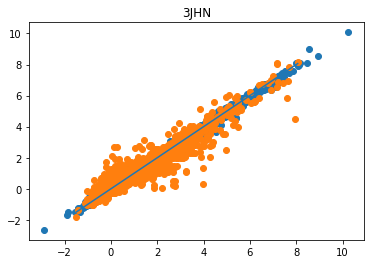

IndexError: list index out of range

In [10]:
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values

    model = models[i]
    
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    plt.scatter(y_train, y_pred_train)
    plt.scatter(y_val, y_pred)
    plt.title('{}'.format(b))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
    plt.show()

In [ ]:
with open(OUTPUT + MODEL, 'wb') as f:
    pickle.dump(models, f)